In [5]:
import pandas as pd
import scipy.stats as sps
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# T-test


Цель данного ноутбука - вручную написать реализацию теста Стьюдента, проверить ее корректность несколькими способами, а так же посмотреть, как работает сам тест на различных данных.

Формула двухвыборочного критерия Стьюдента для случая различных дисперсий: $$\frac{\overline{X_1} - \overline{X_2}}{\sqrt{\frac{\sigma_1^2}{n_1} + \frac{\sigma_2^2}{n_2}}}$$

In [6]:
def compute_t_statistic(X1: np.array, X2: np.array):
  num = np.mean(X1) - np.mean(X2)
  den = np.sqrt(X1.var(ddof=1) / X1.size + X2.var(ddof=1) / X2.size)
  return num / den

In [7]:
N = 1000
diff = [0 for i in range(N)]
for i in range(N):
  X1 = sps.expon.rvs(size=N)
  X2 = sps.expon.rvs(size=N)
  t_stas_custom = compute_t_statistic(X1, X2)
  t_stat, p_value = sps.ttest_ind(X1, X2, equal_var=False)
  diff[i] = np.abs(t_stas_custom - t_stat)

print('Отличия кастомной реализации подсчета t статистики от библиотечной:')
print('Сумма отличий: {}'.format(np.sum(diff)))
print('Среднее отличие: {}'.format(np.mean(diff)))
print('Максимальное: {}'.format(np.max(diff)))

Отличия кастомной реализации подсчета t статистики от библиотечной:
Сумма отличий: 4.0104204679369815e-14
Среднее отличие: 4.0104204679369816e-17
Максимальное: 4.440892098500626e-16


Как можно видеть, написанная функция работает аналогчно библиотечной.

Теперь реализуем подсчет p-value для различных видов теста

In [8]:
def custom_ttest_ind(X1: np.array, X2: np.array, test_type='two-sided'):
  """
    test_type может принимать значения 'two-sided', 'less', 'greater',
      как в sps.ttest_ind
    функция возвращает значение t статистики и p-value
  """
  t_stat = compute_t_statistic(X1, X2)
  X1_var, X2_var = X1.var(ddof=1), X2.var(ddof=1)
  n, m = X1.size, X2.size

  degrees_of_fredom = (X1_var / n + X2_var / m) ** 2 / \
                      (X1_var ** 2 / (n ** 2 * (n - 1)) + X2_var ** 2 / (m ** 2 * (m - 1)))

  if test_type == 'less':
    p_value = sps.t.cdf(x=t_stat, df=degrees_of_fredom)
  elif test_type == 'greater':
    p_value = 1 - sps.t.cdf(x=t_stat, df=degrees_of_fredom)
  elif test_type == 'two-sided':
    p_value = 2 * sps.t.cdf(x=-np.abs(t_stat), df=degrees_of_fredom)
  else:
    print('Incorrect test type')

  return t_stat, p_value

In [9]:
def check_func_diff(f1, f2, test_type='two-sided', N=1000):
  diff = [0 for i in range(N)]
  for i in range(N):
    X1 = sps.expon.rvs(size=N)
    X2 = sps.expon.rvs(size=N)
    t_stas_custom, p_value_custom = f1(X1, X2, test_type=test_type)
    t_stat, p_value = f2(X1, X2, alternative=test_type, equal_var=False)
    diff[i] = np.abs(p_value_custom - p_value)

  print('Сумма отличий: {}'.format(np.sum(diff)))
  print('Среднее отличие: {}'.format(np.mean(diff)))
  print('Максимальное: {}'.format(np.max(diff)))

In [99]:
def separate_print():
  print('--------------------------')

In [100]:
print('Отличия кастомной реализации подсчета p-value от библиотечной с двусторонней альтернативой:')
check_func_diff(custom_ttest_ind, sps.ttest_ind, test_type='two-sided')
separate_print()
print('Отличия кастомной реализации подсчета p-value от библиотечной с левосторонней альтернативой:')
check_func_diff(custom_ttest_ind, sps.ttest_ind, test_type='less')
separate_print()
print('Отличия кастомной реализации подсчета p-value от библиотечной с правосторонней альтернативой:')
check_func_diff(custom_ttest_ind, sps.ttest_ind, test_type='greater')

Отличия кастомной реализации подсчета p-value от библиотечной с двусторонней альтернативой:
Сумма отличий: 4.7802040104016896e-14
Среднее отличие: 4.78020401040169e-17
Максимальное: 5.551115123125783e-16
--------------------------
Отличия кастомной реализации подсчета p-value от библиотечной с левосторонней альтернативой:
Сумма отличий: 2.6302744704498338e-14
Среднее отличие: 2.6302744704498337e-17
Максимальное: 3.3306690738754696e-16
--------------------------
Отличия кастомной реализации подсчета p-value от библиотечной с правосторонней альтернативой:
Сумма отличий: 4.289578132803118e-14
Среднее отличие: 4.289578132803118e-17
Максимальное: 2.7755575615628914e-16


Расчет p_value так же очень близок к библиотечному. Построим график для наглядности

In [10]:
def generate_expon_samples(loc=0, scale=1, n=1000, m=2, sample_size=1000):
  return [[sps.expon.rvs(scale=1, size=sample_size) for i in range(m)] for j in range(n)]

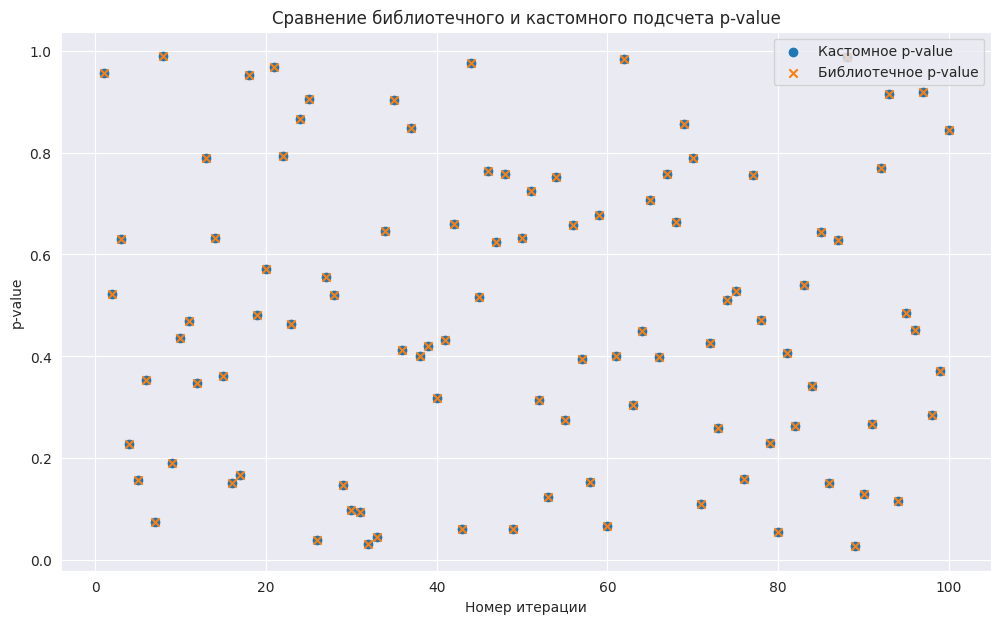

In [102]:
N = 100
M = 2
sample_size = 200

p_value_custom, p_value = [], []
for X1, X2 in generate_expon_samples(n=N, m=M, sample_size=sample_size):
  t1, p1 = custom_ttest_ind(X1, X2)
  t2, p2 = sps.ttest_ind(X1, X2)
  p_value_custom.append(p1)
  p_value.append(p2)

with sns.axes_style("darkgrid"):
  plt.figure(figsize=(12, 7))
  plt.title('Сравнение библиотечного и кастомного подсчета p-value')
  plt.scatter(np.arange(1, N + 1), p_value_custom, label='Кастомное p-value', marker='o', alpha=1)
  plt.scatter(np.arange(1, N + 1), p_value, label='Библиотечное p-value', marker='x', alpha=1)
  plt.xlabel('Номер итерации')
  plt.ylabel('p-value')
  plt.legend()
  plt.show()

Видно, что кастомное и библиотечное значение p-value совпадают, так же заметно, что p-value довольно равномерно распределено на отрезке [0, 1], что так же является признаком корректного теста. Чтобы убедиться в этом построим график плотности p-value.

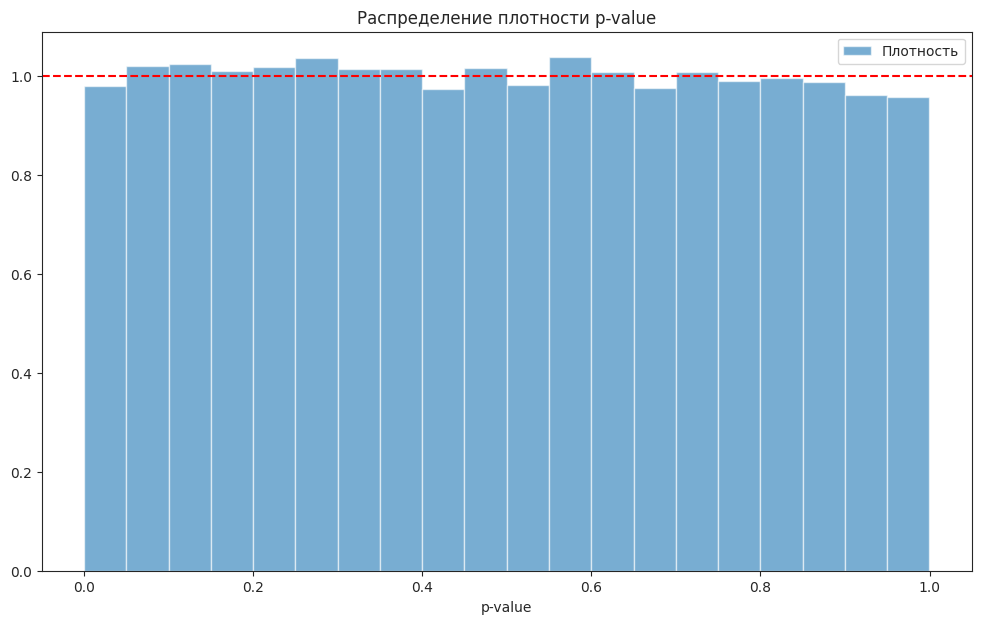

In [103]:
N = 50000
M = 2
sample_size = 200

p_value_custom = []
for X1, X2 in generate_expon_samples(n=N, m=M, sample_size=sample_size):
  t_stat, p_value = custom_ttest_ind(X1, X2)
  p_value_custom.append(p_value)

with sns.axes_style("ticks"):
  plt.figure(figsize=(12, 7))
  plt.title('Распределение плотности p-value')
  plt.hist(p_value_custom, bins=20, label='Плотность', alpha=0.6, density=True)
  plt.axhline(y=1, color='red', linestyle='--')
  plt.xlabel('p-value')
  plt.legend()
  plt.show()

Предположение о равномерности распределения p-value подтвердилось. Теперь добавим функцию, непосредственно проводящую тест и проведем серию AA тестов для валидации. Рассматриваем только случай независимых выборок.

In [11]:
def custom_ttest(X1: np.array, X2: np.array, test_type='two-sided', alpha=0.05):
  """
    test_type может принимать значения 'two-sided', 'less', 'greater',
      как в sps.ttest_ind
    функция возвращает 1, если гипотеза о равенстве средних отвергается и 0,
      если не отвергается
  """
  t_stat, p_value = custom_ttest_ind(X1, X2, test_type)
  return int(p_value < alpha)

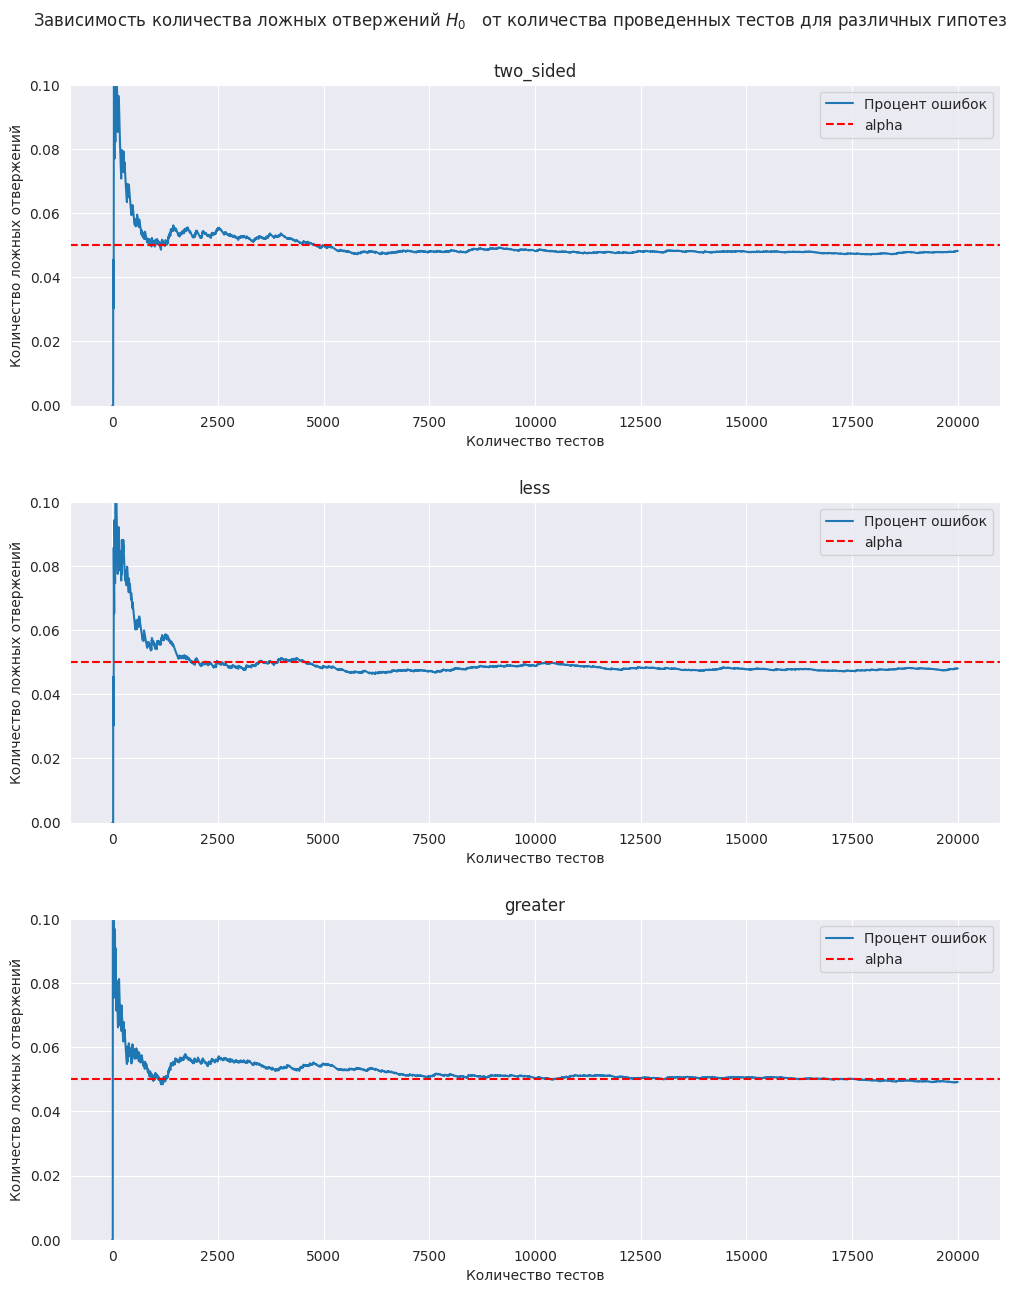

In [105]:
N = 20000

errors_two_sided = np.zeros(N + 1)
errors_less = np.zeros(N + 1)
errors_greater = np.zeros(N + 1)
for i, samples in enumerate(generate_expon_samples(n=N)):
  X1, X2 = samples[0], samples[1]
  errors_two_sided[i + 1] = errors_two_sided[i] + custom_ttest(X1, X2)
  errors_less[i + 1] = errors_less[i] + custom_ttest(X1, X2, test_type='less')
  errors_greater[i + 1] = errors_greater[i] + custom_ttest(X1, X2, test_type='greater')

x = np.arange(1, N + 1)
with sns.axes_style("darkgrid"):
  fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(12, 15))
  plt.suptitle('Зависимость количества ложных отвержений $H_0$ \
  от количества проведенных тестов для различных гипотез', x=0.5, y=0.93)

  axes[0].plot(x, errors_two_sided[1:] / x, label='Процент ошибок')
  axes[0].set_title('two_sided')

  axes[1].plot(x, errors_less[1:] / x, label='Процент ошибок')
  axes[1].set_title('less')

  axes[2].plot(x, errors_greater[1:] / x, label='Процент ошибок')
  axes[2].set_title('greater')

  for i in range(axes.size):
    axes[i].axhline(y=0.05, color='red', linestyle='--', label='alpha')
    axes[i].set_xlabel('Количество тестов')
    axes[i].set_ylabel('Количество ложных отвержений')
    axes[i].set_ylim(0, 0.1)
    axes[i].legend()

  plt.subplots_adjust(hspace=0.3)
  plt.show()

Ожидаемо при увеличении количества тестов процент ложноположительных прокрашиваний все меньше отклоняется от уровня значимости $\alpha$

Построим график, показывающий, как ведет себя доверительный интервал для разности средних нормально распределенных величин в зависимости от размера выборки.

Формула доверительного интервала уровня доверия $1-\alpha$ в случае неизвестных дисперсий:            
$(\overline{X_1} - \overline{X_2} \pm T_{v,1-\alpha/2} * \sqrt{\frac{S^2_{X_1}}{n} + \frac{S^2_{X_2}}{m}})$           
Здесь $S^2_{X_1}, S^2_{X_2}$ - несмещенные оценки дисперсий, $n, m$ - размеры выборок.             
$v = (\frac{S^2_{X_1}}{n} + \frac{S^2_{X_2}}{m}) ^ 2 \div (\frac{S^4_{X_1}}{n^2(n-1)} + \frac{S^4_{X_2}}{m^2(m-1)})$



Мы хотим построить теоретический доверительный интервал, поэтому используем реальные известные значения матожидания и дисперсии

In [12]:
def compute_theoretical_conf_interval(n, m, X1_loc=0, X2_loc=0, X1_scale=1, X2_scale=1, alpha=0.05):
  degrees_of_fredom = (X1_scale ** 2 / n + X2_scale ** 2 / m) ** 2 / \
                      (X1_scale ** 4 / (n ** 2 * (n - 1)) + X2_scale ** 4 / (m ** 2 * (m - 1)))
  q = sps.t.ppf(q = 1 - alpha / 2, df = degrees_of_fredom)
  se = np.sqrt(X1_scale ** 2 / n + X2_scale ** 2 / m)
  mean_diff = X1_loc - X2_loc
  return (mean_diff - q * se, mean_diff + q * se)

In [14]:
def draw_conf_interval(distr1, distr2, get_interval, alpha=0.05, max_sample_size=1000, num_samples=1000, X1_loc=0, X2_loc=0, X1_scale=1, X2_scale=1, draw_error=True, min_sample_size=3):
  lower_border = np.zeros(max_sample_size + 1)
  upper_border = np.zeros(max_sample_size + 1)
  samples_mean_diff = np.zeros(max_sample_size - min_sample_size)
  rolling_means = []

  X1 = distr1.rvs(X1_loc, X1_scale, size=max_sample_size)
  X2 = distr2.rvs(X2_loc, X2_scale, size=max_sample_size)

  for sample_size in range(min_sample_size, max_sample_size + 1):
    interval = get_interval(sample_size, sample_size, X1_loc, X2_loc, X1_scale, X2_scale)
    lower_border[sample_size] = interval[0]
    upper_border[sample_size] = interval[1]

  for i in range(num_samples):
    X1 = distr1.rvs(X1_loc, X1_scale, size=max_sample_size)
    X2 = distr2.rvs(X2_loc, X2_scale, size=max_sample_size)
    X1_c = np.cumsum(X1) / np.arange(1, max_sample_size + 1)
    X2_c = np.cumsum(X2) / np.arange(1, max_sample_size + 1)
    rolling_means.append(X1_c - X2_c)

  plt.figure(figsize=(10, 6))
  plt.title('Зависимость доверительного интервала и разности среднего от размера выборок')
  plt.fill_between(x=np.arange(min_sample_size, max_sample_size + 1),
                   y1=lower_border[min_sample_size:],
                   y2=upper_border[min_sample_size:],
                   alpha=0.3,
                   color='blue',
                   label='Доверительный интервал для разности средних'
                   )
  for i in range(num_samples):
    plt.plot(np.arange(min_sample_size, max_sample_size + 1),
           rolling_means[i][min_sample_size - 1:],
           label='Разница средних',
           c='r',
           alpha=5 / num_samples
           )
  plt.xlabel('Размер выборок')
  plt.ylabel('Значение')

  handles, labels = plt.gca().get_legend_handles_labels()
  dict_of_labels = dict(zip(labels, handles))
  plt.legend(dict_of_labels.values(), dict_of_labels.keys())

  plt.show()
  if draw_error:
    draw_error_rate(rolling_means, lower_border[min_sample_size:], upper_border[min_sample_size:], alpha, shift=min_sample_size-1)

In [13]:
def draw_error_rate(samples, lower_border, upper_border, alpha=0.05, shift=2):
  max_sample_size = samples[0].size
  num_samples = len(samples)
  error = np.zeros(max_sample_size)
  error_diff = np.zeros(max_sample_size)
  for sample_size in range(shift, max_sample_size):
    errors = 0
    for sample_num in range(num_samples):
      if not (samples[sample_num][sample_size] < upper_border[sample_size - shift] and \
              samples[sample_num][sample_size] > lower_border[sample_size - shift]):
        errors += 1
    error[sample_size] = errors / num_samples
    error_diff[sample_size] = np.abs(errors / num_samples - alpha)
  with sns.axes_style("darkgrid"):
    plt.figure(figsize=(10, 6))
    plt.title('Зависимость % выходов за границы доверительного интервала от размера выборок')

    plt.plot(np.arange(1, len(error) + 1),
            error,
            label='% выходов за границы доверительного интервала',
            c='g'
            )
    plt.plot(np.arange(1, len(error) + 1),
            error_diff,
            label=r'Отличие выходов за границы доверительного интервала от $\alpha$ в %',
            c='b'
            )

    plt.axhline(y=alpha,
                color='red',
                linestyle='--',
                label=r'$\alpha$')

    plt.xlabel('Размер выборок')
    plt.ylabel('%')
    plt.legend()
    plt.show()

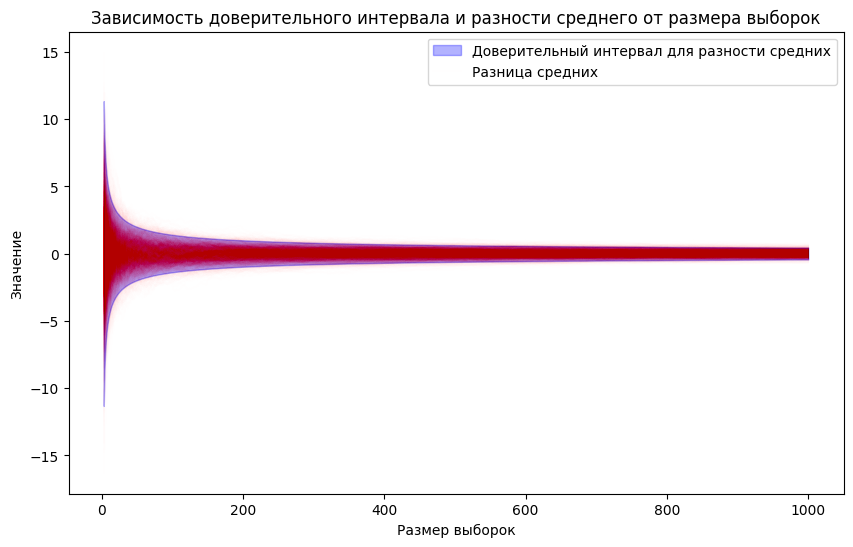

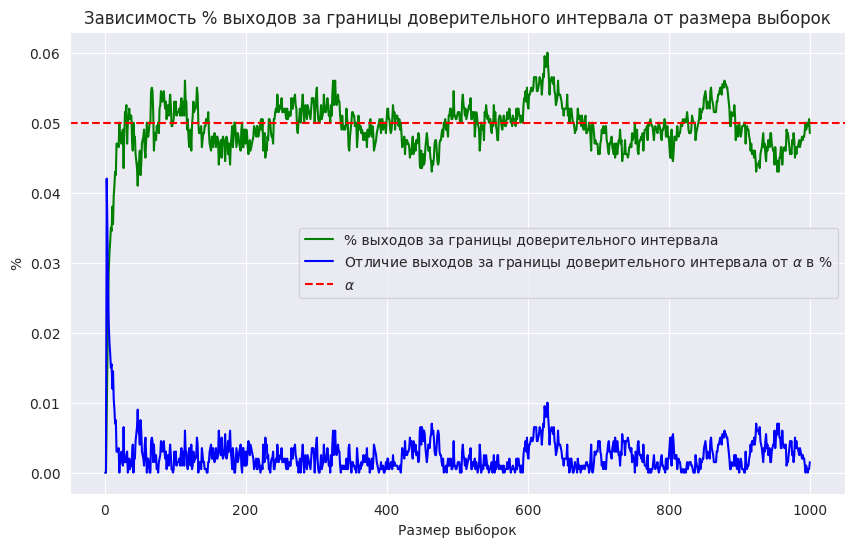

In [54]:
draw_conf_interval(sps.expon, sps.expon, compute_theoretical_conf_interval, max_sample_size=1000, num_samples=2000, X1_loc=5, X2_loc=5, X1_scale=5, X2_scale=5)

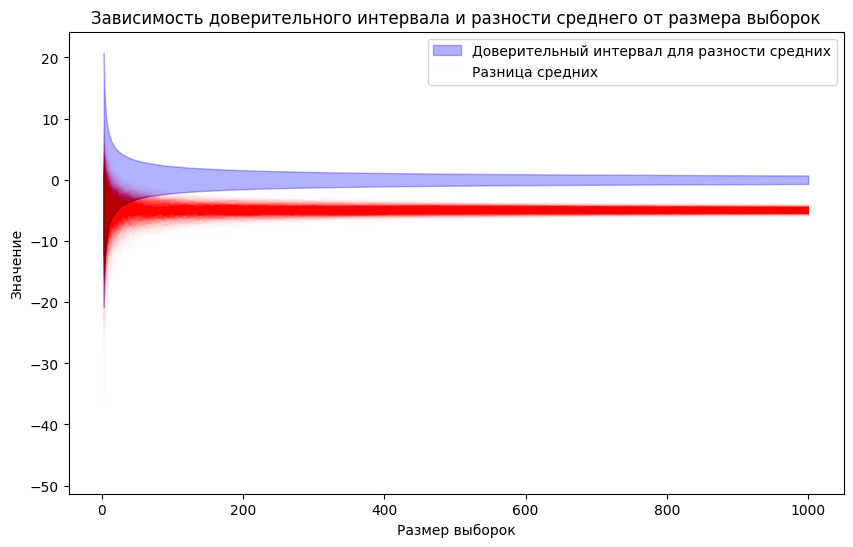

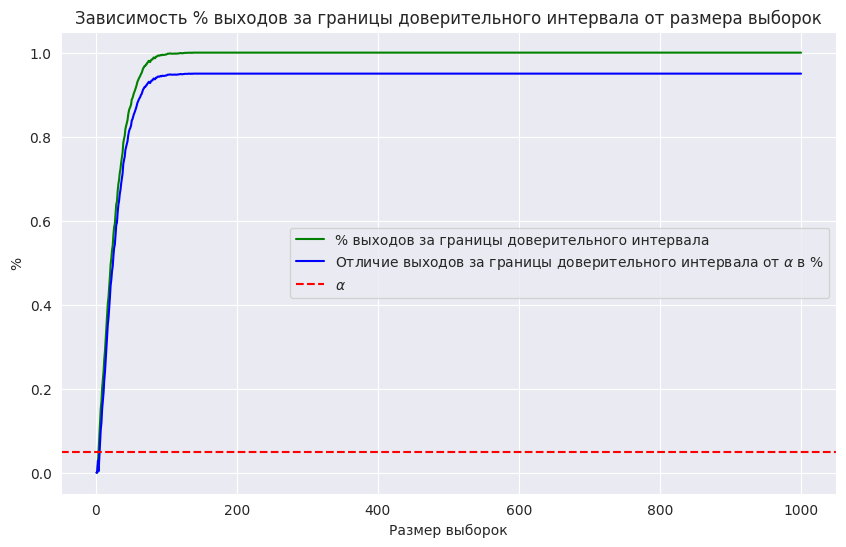

In [53]:
draw_conf_interval(sps.expon, sps.expon, compute_theoretical_conf_interval, max_sample_size=1000, num_samples=2000, X1_loc=5, X2_loc=5, X1_scale=5, X2_scale=10)

Нормальное распределение


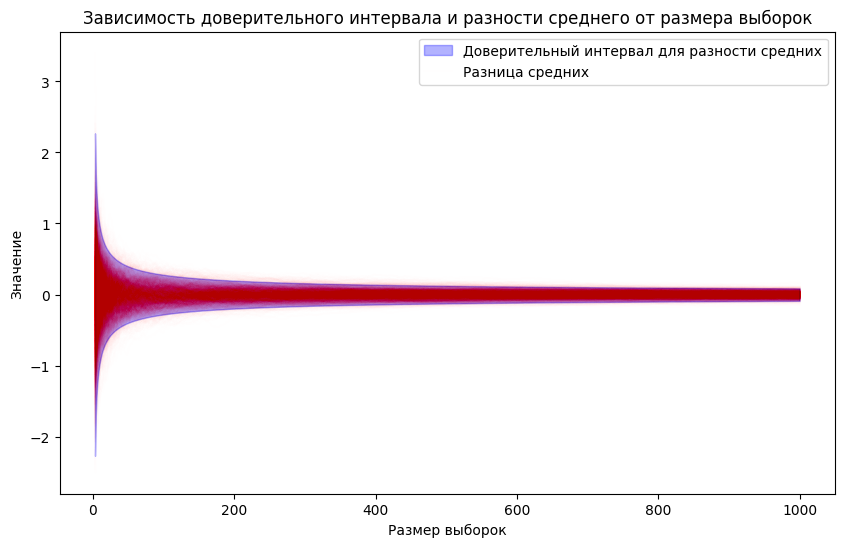

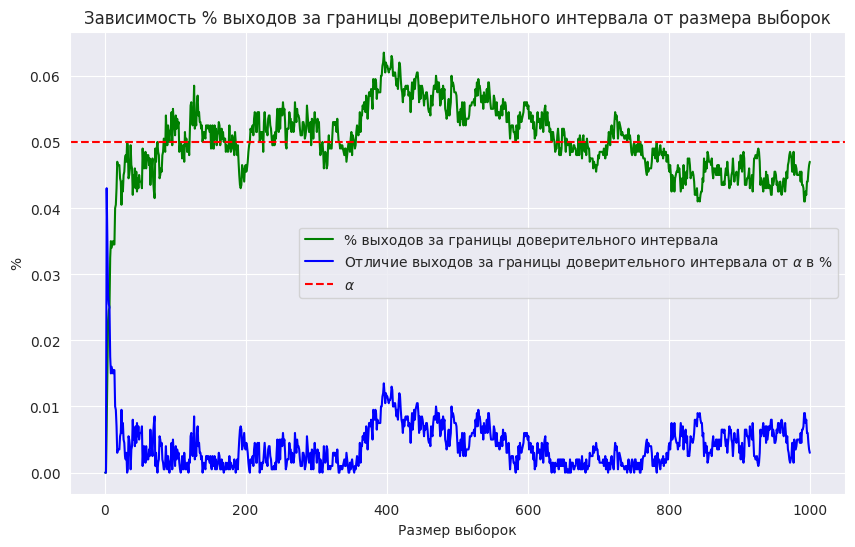

In [114]:
print('Нормальное распределение')
draw_conf_interval(sps.norm, sps.norm, compute_theoretical_conf_interval, max_sample_size=1000, num_samples=2000, X1_loc=1, X2_loc=1, X1_scale=1, X2_scale=1)

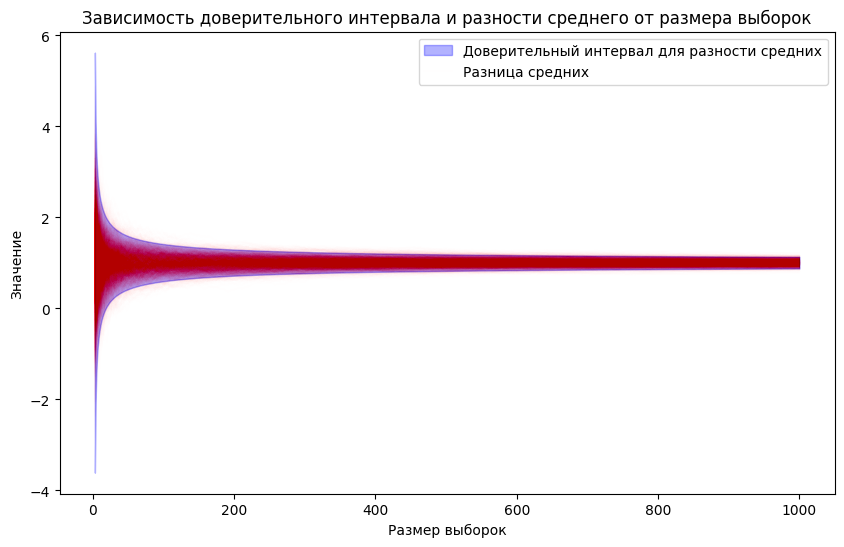

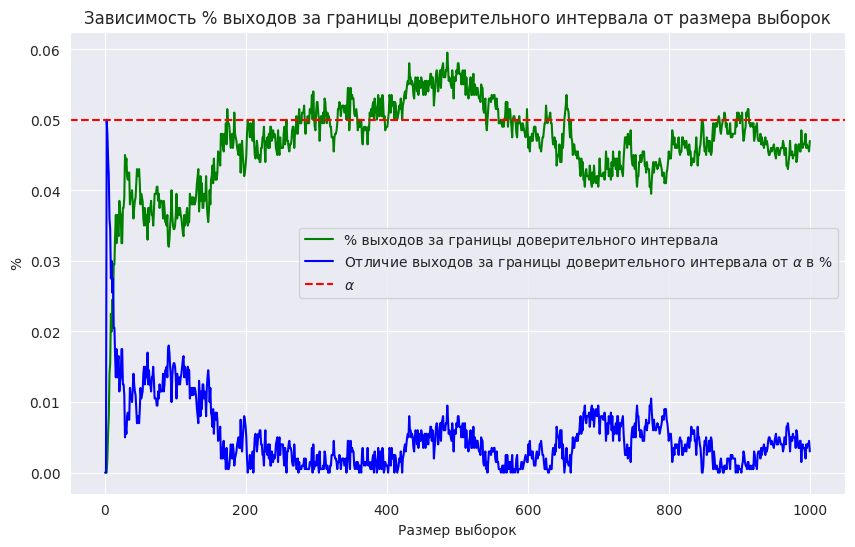

In [115]:
draw_conf_interval(sps.norm, sps.norm, compute_theoretical_conf_interval, max_sample_size=1000, num_samples=2000, X1_loc=2, X2_loc=1, X1_scale=2, X2_scale=0.5)

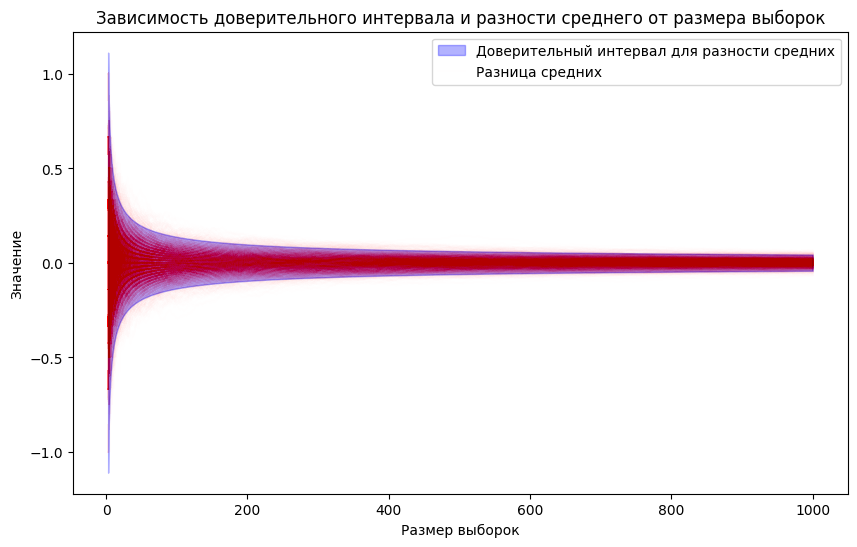

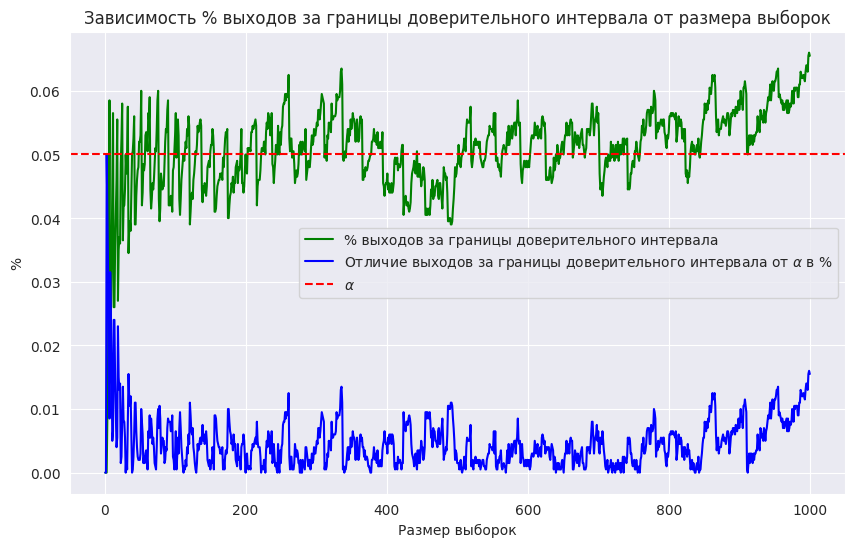

In [116]:
draw_conf_interval(sps.bernoulli, sps.bernoulli, compute_theoretical_conf_interval, max_sample_size=1000, num_samples=2000, X1_loc=0.6, X2_loc=0.6, X1_scale = np.sqrt(0.6 * 0.4), X2_scale = np.sqrt(0.6 * 0.4))

Можно видеть, что доверительный интервая корректно работает в случаях, когда выборки имеют одинаковые распределения с одинаковыми матожем и стандартным отклонением или если обе выборки имеют нормальное распределение возможно с различными параметрами.

Теперь посмотрим на мощность нашего теста. Для этого построим графики зависимости доли отвержения нулевой гипотезы в зависимости от размера выборок и размера эффекта.

In [3]:
from tqdm import tqdm

In [2]:
def get_test_power(distr, sample_size = 1000, num_samples=1000, shift=0):
  n_reject = 0
  for i in range(num_samples):
    n_reject += custom_ttest(distr.rvs(size=sample_size), distr.rvs(size=sample_size) + shift)
  return n_reject / num_samples

In [ ]:
def drow_power_plot_by_effect(distr=sps.norm, shifts=np.arange(0, 1, 0.05), sample_size=1000, num_samples=1000):
  power = np.zeros(shifts.size)
  for ind, shift in tqdm(enumerate(shifts), total=len(shifts)):
    power[ind] = get_test_power(distr, shift=shift, sample_size=sample_size, num_samples=num_samples)

  with sns.axes_style("darkgrid"):
    plt.figure(figsize=(12, 8))
    plt.title('Зависимость мощности независимого теста Стьюдента от размера реального эффекта при наличии {} наблюдений в каждой группе'.format(sample_size))
    plt.plot(shifts, power, lw=4)
    plt.xlabel('Реальный эффект')
    plt.ylabel('Мощность')
    plt.legend()
    plt.show()

100%|██████████| 25/25 [00:15<00:00,  1.62it/s]


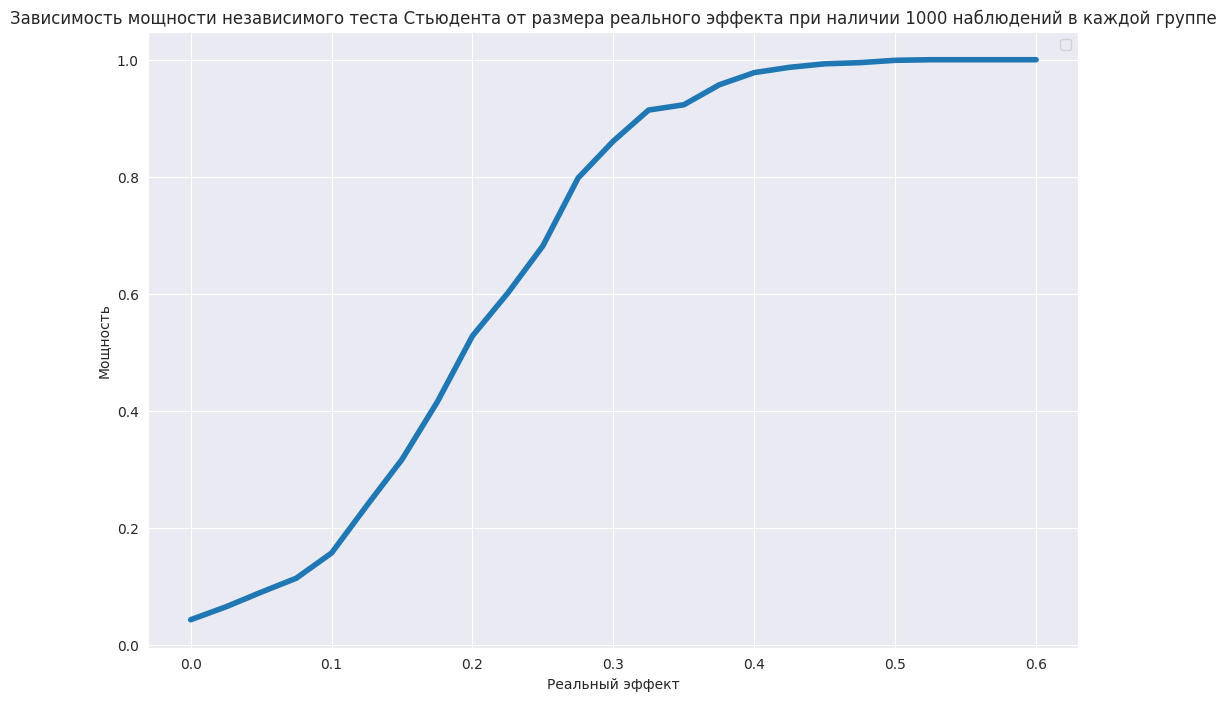

In [20]:
drow_power_plot_by_effect(sps.gamma(a=5), np.arange(0, 0.61, 0.025), sample_size=1000, num_samples=1000)

100%|██████████| 21/21 [00:11<00:00,  1.77it/s]


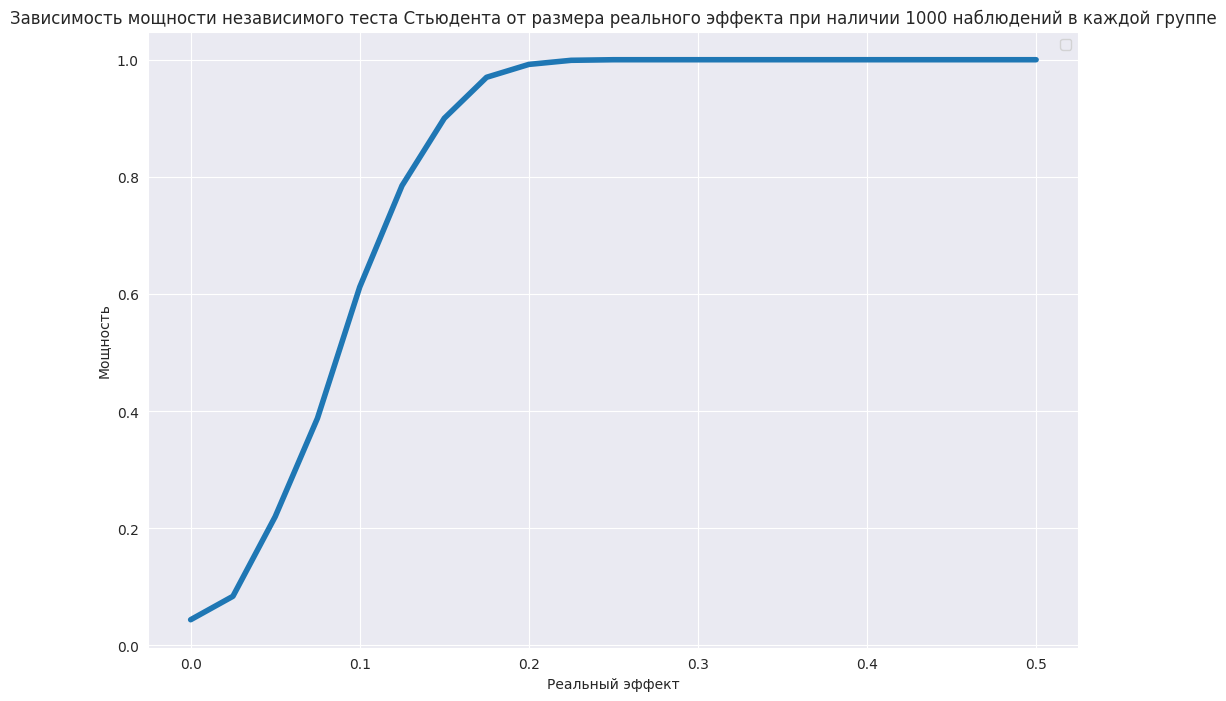

In [21]:
drow_power_plot_by_effect(sps.expon(5), np.arange(0, 0.51, 0.025), sample_size=1000, num_samples=1000)

Ожидаемо при увеличении реального эффекта мощность критерия возрастает, так как его проще детектировать

В работе данный график поможет нам ответить на вопрос о том, какая будет мощность теста, если мы достигнем определенного эффекта или какой уровень эффекта мы можем детектировать при заданной мощности. Все это для фиксированного количества наблюдений (или времени проведения теста, если мы можем предположить его по историческим данным).
Теперь давайте научимся отвечать на вопрос о том, какой размер выборки нам необходим для достижения заданной мощности при фиксированном эффекте.

In [27]:
def drow_power_plot_by_sample_size(distr=sps.norm, shift = 0.1, num_samples=1000, min_sample_size=3, max_sample_size=1000):
  power = np.zeros(max_sample_size + 1)
  for sample_size in tqdm(range(min_sample_size, max_sample_size + 1)):
    power[sample_size] = get_test_power(distr, shift=shift, sample_size=sample_size, num_samples=num_samples)

  with sns.axes_style("darkgrid"):
    plt.figure(figsize=(12, 8))
    plt.title('Зависимость мощности независимого теста Стьюдента от числа наблюдейний в каждой группе при реальном эффекте {}'.format(shift))
    plt.plot(np.arange(min_sample_size, max_sample_size + 1), power[min_sample_size:], lw=4)
    plt.xlabel('Количество наблюдейний в каждой группе')
    plt.ylabel('Мощность')
    plt.legend()
    plt.show()

100%|██████████| 998/998 [07:49<00:00,  2.13it/s]


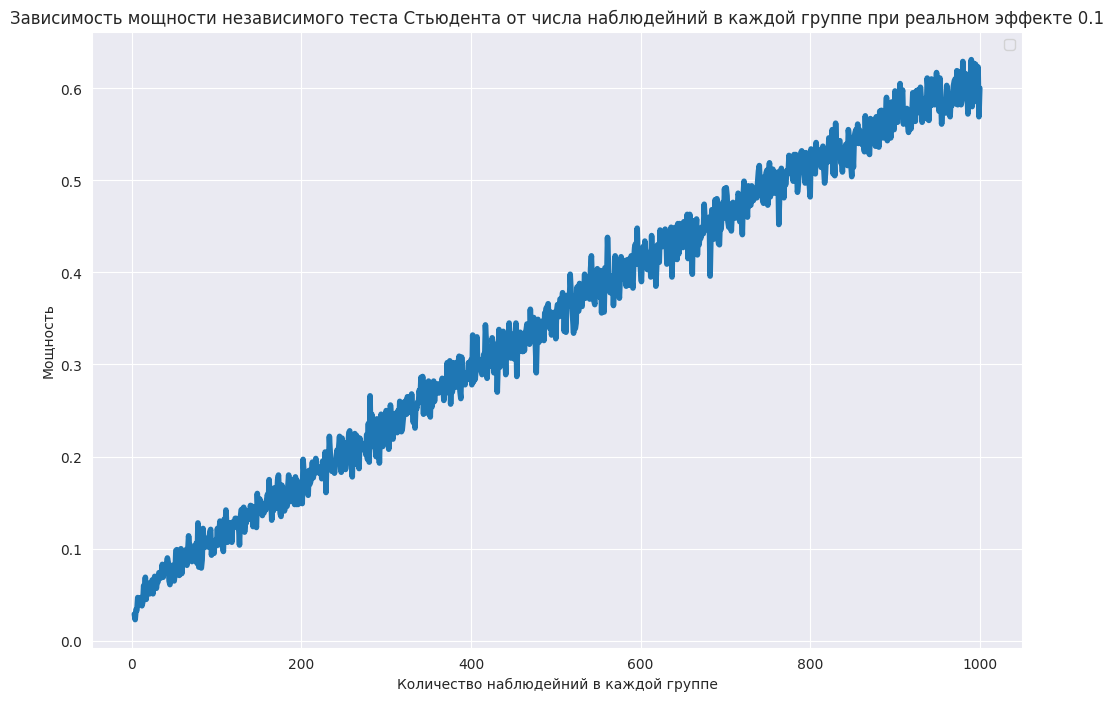

In [29]:
drow_power_plot_by_sample_size(sps.expon(5), max_sample_size=1000, num_samples=1000)

График получился шумный, но на нем хорошо видна тенденция роста мощности при увеличении размера выборок.

Давайте объединим два предыдущих графика, чтобы получить зависимость сразу от двух параметров

In [46]:
def drow_power_plot_by_sample_size_and_effect(distr=sps.norm, shifts=np.linspace(0, 1, 10), num_samples=100, min_sample_size=3, max_sample_size=100):
  power = np.zeros((max_sample_size + 1, len(shifts)))
  for sample_size in tqdm(range(min_sample_size, max_sample_size + 1)):
    for ind, shift in enumerate(shifts):
      power[sample_size, ind] = get_test_power(distr, shift=shift, sample_size=sample_size, num_samples=num_samples)

  plt.figure(figsize=(12, 7))
  plt.imshow(power.T, cmap='hot', origin='lower', aspect='auto', interpolation='quadric', extent=[min_sample_size, max_sample_size, shifts[0], shifts[-1]])
  plt.colorbar(label='Мощность')
  # plt.xticks(np.arange(min_sample_size, max_sample_size + 1))
  # plt.yticks(shifts)
  plt.xlabel('Количество наблюдений в выборках')
  plt.ylabel('Реальный эффект')
  plt.title('Зависимость мощности от размера выборки и реального эффекта')

  plt.show()

100%|██████████| 98/98 [07:37<00:00,  4.67s/it]


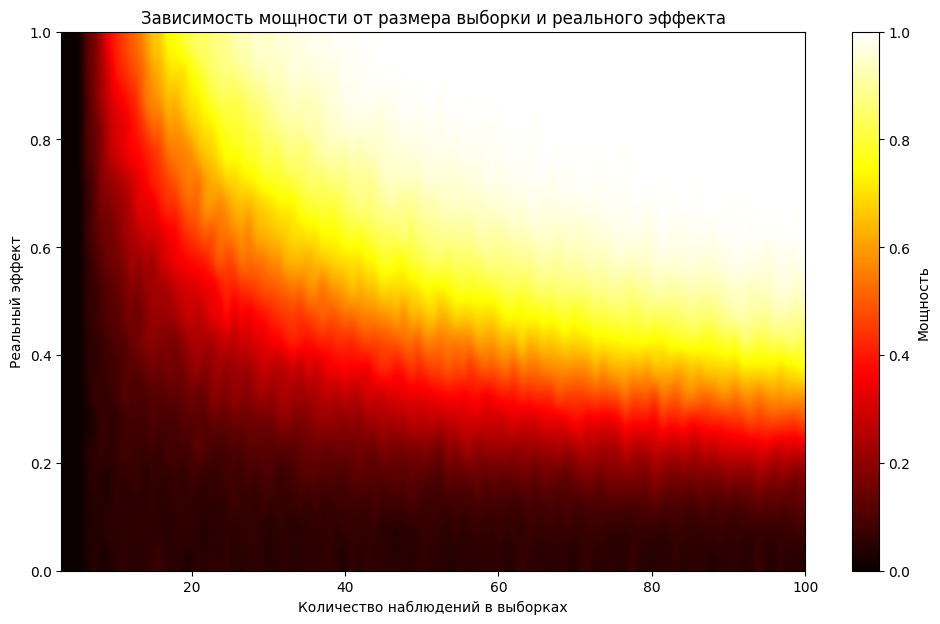

In [49]:
drow_power_plot_by_sample_size_and_effect(shifts=np.linspace(0, 1, 20), num_samples=500)

В принципе то что мощность растем вместе с ростом эффекта и размера выборки мы и так знали, но от красивой визуализации хуже не будет)